In [180]:
import sklearn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import torch
import ast
from joblib import dump, load
from sklearn.pipeline import Pipeline
import pickle
from IPython.display import Markdown

import os
import re
import torch.nn as nn
import random
plt.figure(dpi=150)
import cProfile
import torch
import torch.optim as optim
import torch.nn.utils as utils
import wandb
import pdb
from utils_human_exp import *
from utils import *

<Figure size 960x720 with 0 Axes>

In [181]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
GRID_SIZE = 10

# wandb.login(relogin=True)
# os.environ['WANDB_API_KEY'] = "71f0a53fa4cb62b56494f6554ec1a5e3b898a7dd"
# wandb.login(key="71f0a53fa4cb62b56494f6554ec1a5e3b898a7dd")

In [182]:
# Check if the WANDB_API_KEY is set
if "WANDB_API_KEY" in os.environ:
    print("Logged in with API key.")
    user_info = wandb.api.viewer()
    print("Current user:", user_info["entity"], user_info["username"])
else:
    print("Not logged in.")

Not logged in.


# CNN approach to predicting WCD

In [183]:
#f"simulated_valids_final{GRID_SIZE}.pkl"
if GRID_SIZE == 6:
    datasets = ["data0.npz","data1.npz","data2.npz","data3.npz","data4.npz","data5.npz","data6.npz","data7.npz","data8.npz","data9.npz"]
else:
    datasets = [f"data{k}.npz" for k in range(0,30)]+[f"data_{k}.npz" for k in range(0,30)]+[f"data_1{k}.npz" for k in range(10,30)]+[f"data_0{k}.npz" for k in range(0,30)]+[f"data_2{k}.npz" for k in range(10,30)]+[f"data_44{k}.npz" for k in range(0,30)]
    datasets = datasets+[f"data_45{k}.npz" for k in range(0,30)]+[f"data_48{k}.npz" for k in range(0,30)]
    
loaded_data = {}
dataset=datasets[0]
x_data = []
y_data = []
for dataset in datasets:
    if not os.path.exists(f"data/grid{GRID_SIZE}/model_training/path_model/{dataset}"): continue
    
    data = np.load(f"data/grid{GRID_SIZE}/model_training/path_model/{dataset}")
    x_data.append(data["layouts"])
    y_data.append(data["wcds"])


X = np.concatenate(x_data)
Y = np.concatenate(y_data)
# X = X[Y>=0]
# Y = Y[Y>=0]
print(X.shape, Y.shape)
X = X[Y>=0]
Y = Y[Y>=0]
print(X.shape, Y.shape)

(8450000, 4, 10, 10) (8450000,)
(8316782, 4, 10, 10) (8316782,)


In [184]:
x_data = None
y_data = None
data = None

In [185]:
np.min(Y), np.max(Y)

(0, 30)

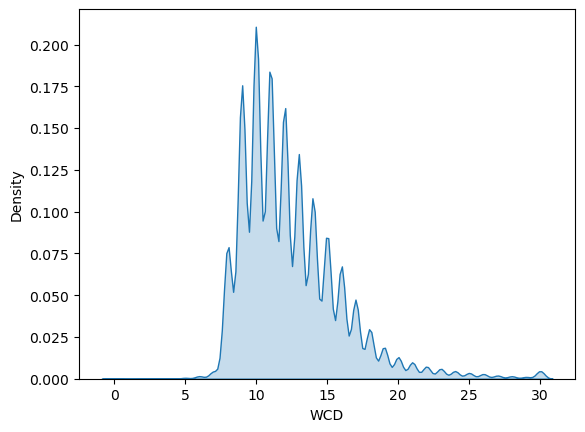

In [186]:
sns.kdeplot(Y,fill=True,bw_adjust=2)
plt.xlabel("WCD")
plt.show()

In [187]:
X.shape, Y.shape

((8316782, 4, 10, 10), (8316782,))

In [188]:
def tensor_memory_usage(tensor):
    size_in_bytes = tensor.element_size() * tensor.nelement()
    size_in_gb = size_in_bytes / (1024 ** 3)
    return size_in_gb


print(f"Memory usage of tensor: {tensor_memory_usage(torch.tensor(X)):.6f} GB")
print(f"Memory usage of tensor: {tensor_memory_usage(torch.tensor(Y)):.6f} GB")

Memory usage of tensor: 24.785942 GB
Memory usage of tensor: 0.061965 GB


In [189]:
import psutil

def get_memory_info():
    memory_info = psutil.virtual_memory()
    total_memory = memory_info.total / (1024 ** 3)  # Convert bytes to GB
    available_memory = memory_info.available / (1024 ** 3)  # Convert bytes to GB
    used_memory = memory_info.used / (1024 ** 3)  # Convert bytes to GB

    print(f"Total Memory: {total_memory:.2f} GB")
    print(f"Available Memory: {available_memory:.2f} GB")
    print(f"Used Memory: {used_memory:.2f} GB")

get_memory_info()

Total Memory: 503.01 GB
Available Memory: 398.33 GB
Used Memory: 101.41 GB


In [190]:
# Total Memory: 503.32 GB
# Available Memory: 381.94 GB
# Used Memory: 116.22 GB
# Total Memory: 503.32 GB
# Available Memory: 417.65 GB
# Used Memory: 80.51 GB

# 116.22-80.51

In [191]:
def augment_data(chunk):
    augmented_chunk = np.concatenate([
        chunk,
        chunk[:, :, :, ::-1],        # Flip along the last axis
        chunk[:, :, ::-1, :],        # Flip along the second to last axis
        np.rot90(chunk, k=1, axes=(2, 3)), # Rotate 90 degrees
        np.rot90(chunk, k=3, axes=(2, 3)), # Rotate 270 degrees
        np.rot90(chunk, k=2, axes=(2, 3)), # Rotate 180 degrees
        chunk.transpose(0, 1, 3, 2)  # Transpose axes
    ])
    return augmented_chunk

# Assuming X and Y are already loaded into memory
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)
X, Y = None, None  # Free up memory

chunk_size = 2048*200 # Define the size of each chunk
num_chunks = len(x_train) // chunk_size + (1 if len(x_train) % chunk_size != 0 else 0)

x_train_path = "data/grid10/model_training/train_test/x_train.npy"
y_train_path = "data/grid10/model_training/train_test/y_train.npy"

# Open files for writing
x_train_file = open(x_train_path, 'wb')
y_train_file = open(y_train_path, 'wb')

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min(start_idx + chunk_size, len(x_train))
    
    x_chunk = x_train[start_idx:end_idx]
    y_chunk = y_train[start_idx:end_idx]
    
    # Augment data
    x_augmented = augment_data(x_chunk)
    y_augmented = np.concatenate([y_chunk, y_chunk,y_chunk, y_chunk, y_chunk, y_chunk, y_chunk])
    
    # Save augmented data to file
    np.save(x_train_file, x_augmented)
    np.save(y_train_file, y_augmented)
    
    print(f'Processed chunk {i+1}/{num_chunks}')
    
# Close the files
x_train_file.close()
y_train_file.close()

n_channels = x_train.shape[1]
# Clear variables to free up memory
x_train, y_train, x_chunk, y_chunk, x_augmented, y_augmented = None, None, None, None, None, None

# Save the test data
np.save("data/grid10/model_training/x_test.npy", x_test)
np.save("data/grid10/model_training/y_test.npy", y_test)

Processed chunk 1/19
Processed chunk 2/19
Processed chunk 3/19
Processed chunk 4/19
Processed chunk 5/19
Processed chunk 6/19
Processed chunk 7/19
Processed chunk 8/19
Processed chunk 9/19
Processed chunk 10/19
Processed chunk 11/19
Processed chunk 12/19
Processed chunk 13/19
Processed chunk 14/19
Processed chunk 15/19
Processed chunk 16/19
Processed chunk 17/19
Processed chunk 18/19
Processed chunk 19/19


In [192]:
# x_train,x_test, y_train,y_test = train_test_split(X,Y, test_size=0.10)
# X,Y =None, None
# # x_train = np.concatenate([x_train[:, :, :, ::-1],x_train,x_train[:, :, ::-1, :],np.rot90(x_train, k=1, axes=(2, 3)),
# #                           np.rot90(x_train, k=3, axes=(2, 3)),np.rot90(x_train, k=2, axes=(2, 3)),
# #                           x_train.transpose(0, 1, 3, 2)])

# # y_train = np.concatenate([y_train,y_train,y_train,y_train,y_train,y_train,y_train]) ,np.rot90(x_train, k=3, axes=(2, 3))

# x_train = np.concatenate([x_train[:, :, :, ::-1],x_train[:, :, ::-1, :],np.rot90(x_train, k=1, axes=(2, 3)),x_train])
# np.save("data/grid10/model_training/x_train.npy", x_train)
# x_train = None
# y_train = np.concatenate([y_train,y_train,y_train,y_train])
# np.save("data/grid10/model_training/y_train.npy", y_train)
# y_train = None
# x_train.shape, x_test.shape

In [193]:
# tensor_memory_usage(torch.tensor(x_train)), tensor_memory_usage(torch.tensor(y_train))

In [194]:
# print(f"Memory usage of tensor: {tensor_memory_usage(torch.tensor(x_train)):.6f} GB")
# print(f"Memory usage of tensor: {tensor_memory_usage(torch.tensor(y_train)):.6f} GB")

In [195]:
# out_sample_set = CustomDataset(x_test,y_test)
# with open(f"data/grid{GRID_SIZE}/model_training/dataset_{GRID_SIZE}.pkl", "wb") as f:
#     pickle.dump(out_sample_set, f)

In [196]:
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test, test_size=0.95, random_state=50)
x_val.shape, x_test.shape

((790096, 4, 10, 10), (41583, 4, 10, 10))

In [197]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import wandb

In [198]:
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(np.array(y_test)).float()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(np.array(y_val)).float()

In [199]:
class CustomCNN(nn.Module):
    def __init__(self, n_channels=13,drop_out = 0.01,size = 3):
        super(CustomCNN, self).__init__()

        # First block (no pooling)
        self.conv1 = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # Second block with pooling
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        # # Second block with pooling
        # self.conv3 = nn.Sequential(
        #     nn.Conv2d(256, 256, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.Conv2d(256, 512, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU()
        # )


        self.conv_output_size = 256 * size*size
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.conv_output_size, 16), # 3 for 6 & 7 
            nn.LeakyReLU(),
            # nn.Dropout(0.01),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(8, 1),
            nn.ReLU()
        )
        

    def forward(self, x):
        x = self.conv1(x)
        # pdb.set_trace()
        x = self.conv2(x)
        # x = self.conv3(x)
        # print(x.shape)
        x = x.view(-1, self.conv_output_size)
        x = self.fc_layers(x)
        return x

In [200]:
def evaluate_and_log(best_model, x_val, y_val, epoch, wandb=None):
    def predict_in_batches(model, x, batch_size):
        n_batches = len(x) // batch_size + (len(x) % batch_size != 0)
        all_preds = []
        
        for i in range(n_batches):
            x_batch = x[i * batch_size: (i + 1) * batch_size]
            preds_batch = model(x_batch.cuda()).detach()
            all_preds.append(preds_batch)
        
        return torch.cat(all_preds, dim=0).cpu()

    val_pred = predict_in_batches(best_model, x_val, 1024)  # Adjust batch size as per memory needs
    
    if wandb:
        wandb.log({
            "epoch": epoch,
            "mse_val_small": nn.MSELoss()(val_pred[y_val <= GRID_SIZE/2], y_val.view(-1, 1)[y_val <= GRID_SIZE/2]).item(),
            "mse_val_big": nn.MSELoss()(val_pred[y_val > GRID_SIZE/2], y_val.view(-1, 1)[y_val > GRID_SIZE/2]).item(),
            "mse_val_loss": nn.MSELoss()(val_pred, y_val.view(-1, 1)).item(),
            "val_loss": nn.HuberLoss()(val_pred, y_val.view(-1, 1)).item(),
            "valid_mean_wcd": val_pred[y_val != INVALID_WCD].mean(),
            "invalid_mean_wcd": val_pred[y_val == INVALID_WCD].mean(),
            "valid_h_loss": nn.HuberLoss()(val_pred[y_val != INVALID_WCD], y_val.view(-1, 1)[y_val != INVALID_WCD]).item(),
            "invalid_h_loss": nn.HuberLoss()(val_pred[y_val == INVALID_WCD], y_val.view(-1, 1)[y_val == INVALID_WCD]).item(),
            "valid_mse_loss": nn.MSELoss()(val_pred[y_val != INVALID_WCD], y_val.view(-1, 1)[y_val != INVALID_WCD]).item(),
            "invalid_mse_loss": nn.MSELoss()(val_pred[y_val == INVALID_WCD], y_val.view(-1, 1)[y_val == INVALID_WCD]).item(),
        })
    return nn.HuberLoss()(val_pred, y_val.view(-1, 1)).item() ,nn.MSELoss()(val_pred, y_val.view(-1, 1)).item()

In [201]:
# batch_size = 2048 #512 for smaller (6,7,8)
# dataset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(np.array(y_train)).float())
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [202]:
class NpyDataset(Dataset):
    def __init__(self, x_file, y_file, chunk_size=2048):
        self.x_data = np.load(x_file, mmap_mode='r')
        self.y_data = np.load(y_file, mmap_mode='r')
        self.chunk_size = chunk_size

        assert len(self.x_data) == len(self.y_data), "Mismatch in X and Y lengths"

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        # Fetch the sample at the specified index
        x_sample = self.x_data[idx]
        y_sample = self.y_data[idx]

        # Optionally, add a channel dimension if needed
        if len(x_sample.shape) == 2:  # Assuming 2D data that needs a channel dimension
            x_sample = np.expand_dims(x_sample, axis=0)

        return torch.tensor(x_sample, dtype=torch.float32), torch.tensor(y_sample, dtype=torch.float32)

# Usage
x_file_path = 'data/grid10/model_training/train_test/x_train.npy'
y_file_path = 'data/grid10/model_training/train_test/y_train.npy'
chunk_size = 2048

dataset = NpyDataset(x_file_path, y_file_path, chunk_size=chunk_size)
dataloader = DataLoader(dataset, batch_size=chunk_size, shuffle=True,num_workers =4)

In [203]:
if GRID_SIZE in [6,7,8]:
    dropout = 0.01
    lambda_l2 =0.0 #0.1 regularization strength
    grad_clip =1e-3 # 1e-3 for 6,7,8
    lr=0.001 #0.005 for 6,7,8
    num_epochs = 10# 3 for 6,7,8
else:
    dropout = 0.1
    lambda_l2 =0.01 #0.1 regularization strength
    grad_clip =1e-3 # 1e-3 for 6,7,8
    lr=0.005 #0.005 for 6,7,8
    num_epochs = 30# 3 for 6,7,8
    


In [204]:
# model = CustomCNN(n_channels=x_train.shape[1],drop_out=dropout,size = GRID_SIZE//2).cuda() #GRID_SIZE//2
random_seed=123
torch.manual_seed(seed=random_seed)
np.random.seed(random_seed)
random.seed(random_seed)



model = CustomCNN(n_channels=x_test.shape[1],drop_out=dropout,size = GRID_SIZE//2).cuda() #
# model = torch.load("models/wcd_nn_oracle_july6.pt")

In [205]:
x_val.shape

torch.Size([790096, 4, 10, 10])

In [206]:
# # init_model = torch.load("models/wcd_10_init.pt")
# init_model = torch.load(f"../models/wcd_nn_model_{GRID_SIZE}_best.pt") 

# model = init_model
# model.dropout1 = nn.Dropout(dropout)

In [207]:
import psutil
import os

def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / 1024 ** 2  # Convert bytes to MB

In [208]:
total_params = 0
for parameter in model.parameters():
    # print(parameter.shape)
    total_params += parameter.numel()  # numel() returns the total number of elements in the tensor

print(f"Total number of parameters: {total_params}") #636673

Total number of parameters: 659745


In [209]:
x_test[0].sum(),x_test[1].sum(),x_test[20].sum()

(tensor(100.), tensor(100.), tensor(100.))

In [210]:
# model = VGGNet(n_channels = x_train.shape[1]).cuda()

In [211]:
use_wandb = False

if use_wandb:
    wandb.init(project='gridworld', save_code=False, config={"lambda_l2": lambda_l2, "grad_clip":grad_clip,
                                                              "n_train":x_train.shape[0],"GRID_SIZE":GRID_SIZE,"dropout":dropout,
                                                              "lr":lr,"batch_size":batch_size, "experiment":"gridworld"})
# create dataset and dataloader
# initialize model and optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12,25,45,55], gamma=0.5)

# training loop

best_model = model
log_interval = 2

def train():
    training_loss = []
    val_mse_loss =[]
    val_huber_loss = []
    x_epochs = []
    
    lowest_loss = torch.inf
    for epoch in range(num_epochs):
        for i, (inputs, targets) in enumerate(dataloader):
            optimizer.zero_grad()
            
            # Print memory usage before processing batch
            # print(f"Memory usage before batch {i + 1}: {get_memory_usage():.2f} MB")
            # print(inputs[:,0,:,:].mean())
            # forward pass
            outputs = model(inputs.cuda())
            # targets = targets.cuda()

            # compute loss and perform backpropagation
            y_true = targets.view(-1, 1).cuda()
            loss = nn.MSELoss()(outputs, y_true)
            mse_loss = loss.item()
            
            # l2_reg = lambda_l2 * torch.norm(torch.cat([p.view(-1) for p in model.parameters()]), p=2)  # L2 regularization term
            # loss += l2_reg
            
            loss.backward()
            utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            if loss < lowest_loss:
                lowest_loss = loss.item()
                best_model = model
            
            if (i + 1) % 500*log_interval == 0:
                if use_wandb:
                    wandb.log({"loss": mse_loss})
                print(mse_loss)
                
        print(epoch,mse_loss)
        if (epoch + 1) % log_interval == 0:
            val_huber,val_mse = evaluate_and_log(best_model, x_val, y_val, epoch, wandb=wandb if use_wandb else None )
            val_mse_loss.append(val_mse)
            val_huber_loss.append(val_huber)
            training_loss.append(mse_loss)
            x_epochs.append(epoch)
            print("Validation:", epoch," == ", val_mse)
            # plt.plot(x_epochs,training_loss, label="Training")
            # plt.plot(x_epochs,val_mse_loss, label="Validation")
            # plt.show()
            
        scheduler.step()
        torch.save(best_model, f"models/wcd_nn_model_{GRID_SIZE}.pt")
    return x_epochs,training_loss,val_mse_loss
#     plt.plot(x_epochs,training_loss, label="Training")
#     plt.plot(x_epochs,val_mse_loss, label="Validation")

#     # Adding labels
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.title("Training and Validation MSE Loss")

#     # Setting y-axis limits and grid lines in intervals of 5
#     # plt.ylim(0, 30)
#     # plt.yticks(range(0, 21, 5))
#     plt.grid(axis='y')

#     plt.legend()
#     plt.show()
print('Starting Training')
# Start profiling
profiler = cProfile.Profile()
profiler.enable()

# Run the training loop
x_epochs,training_loss,val_mse_loss=train()

# Stop profiling
profiler.disable()
# profiler.print_stats()

wandb.finish()


Starting Training
12.098634719848633
11.736257553100586
0 10.598841667175293
9.063814163208008
7.26655387878418
1 6.780807971954346
Validation: 1  ==  6.607722759246826
5.510829925537109
5.930331230163574
2 6.56407356262207
5.252681732177734
6.097271919250488
3 6.158463954925537
Validation: 3  ==  5.82595157623291
5.015611171722412
5.517246246337891
4 5.263473033905029
5.137824058532715
4.945470809936523
5 5.055509567260742
Validation: 5  ==  5.686938762664795
5.6763200759887695
4.673867225646973
6 5.243423938751221
4.747354507446289
4.096061706542969
7 4.720071315765381
Validation: 7  ==  5.57677698135376
5.208209991455078
4.801302909851074
8 5.004207611083984
5.595516204833984
4.692556381225586
9 5.017125606536865
Validation: 9  ==  5.327796936035156
4.356827735900879
4.167499542236328
10 4.615546703338623
3.734164237976074
4.2822675704956055
11 4.641742706298828
Validation: 11  ==  5.473937511444092
3.968722343444824
4.4251885414123535
12 3.546816825866699
3.9502477645874023
3.75892

Text(0.5, 1.0, 'Training and Validation MSE Loss')

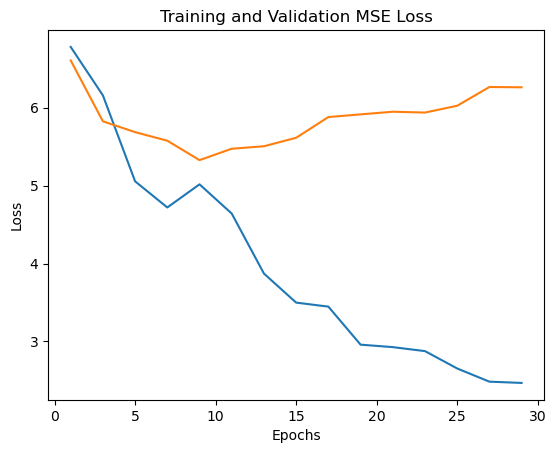

In [212]:
plt.plot(x_epochs,training_loss, label="Training")
plt.plot(x_epochs,val_mse_loss, label="Validation")

    # Adding labels
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation MSE Loss")

In [213]:
# nn.HuberLoss()(best_model(x_test),y_test.view(-1, 1))

In [214]:
torch.mean(abs(best_model(x_test)-y_test.view(-1, 1)))

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
torch.mean(abs(best_model(x_test)-y_test.view(-1, 1)))

In [ ]:
# KDE plot for predicted values with fill color as blue
sns.kdeplot(best_model(x_test).cpu().detach().numpy(), fill=True, color='blue', label="Pred")

# KDE plot for true values with fill color as orange
sns.kdeplot(y_test.view(-1, 1).cpu().detach().numpy(), fill=True, color='orange', label="True")

# Display legend
plt.legend()

# Show plot
plt.show()

In [ ]:
torch.save(best_model,f"models/wcd_nn_oracle_{GRID_SIZE}.pt")

In [ ]:
x_test.shape

In [ ]:
4096*2

In [ ]:
import os
import subprocess

def get_current_jupyter_pid():
    # Get the current notebook's PID from the environment
    ppid = os.getppid()
    return ppid

def get_lsf_job_by_pid(pid):
    # Use the bjobs command to list all jobs for the current user
    result = subprocess.run(['bjobs', '-u', os.getenv('USER')], capture_output=True, text=True)
    for line in result.stdout.splitlines():
        if str(pid) in line:
            # Extract the job ID from the line
            job_id = line.split()[0]
            return job_id
    return None

def get_lsf_job_details(job_id):
    # Get detailed information about the job
    result = subprocess.run(['bjobs', '-l', job_id], capture_output=True, text=True)
    return result.stdout

# Step 1: Get the PID of the current Jupyter Lab server
jupyter_pid = get_current_jupyter_pid()
print(f"Current Jupyter Lab PID: {jupyter_pid}")

# Step 2: Find the corresponding LSF job ID
if jupyter_pid:
    lsf_job_id = get_lsf_job_by_pid(jupyter_pid)
    if lsf_job_id:
        print(f"LSF Job ID: {lsf_job_id}")
        
        # Step 3: Get and print the LSF job details
        job_details = get_lsf_job_details(lsf_job_id)
        print(f"LSF Job Details:\n{job_details}")
    else:
        print("No matching LSF job found for the given PID.")
else:
    print("Jupyter Lab PID not found.")

